In [1]:
import copy
import os, sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats.mstats import zscore

os.chdir('../')

# loa my modules
from src.utils import load_pkl
from src.visualise import *

In [2]:
import joblib
import pickle

In [53]:
dat_path = './data/processed/dict_SCCA_data_prepro_06092017.pkl'
model_path = './models/SCCA_Yeo7_4_0.50_0.70.pkl'
df_path = './data/processed/NYCQ_CCA_score_Yeo7_4_0.5_0.7.pkl'
# load data
dataset = load_pkl(dat_path)
model = joblib.load(model_path)
df = pd.read_pickle(df_path)

In [4]:
model.cancorr_

array([ 0.22064741,  0.28987046,  0.25299064,  0.26006618])

In [54]:
u, v = model.u * [1, 1, -1, 1], model.v * [1, 1, -1, 1] # reverse nuber one for intepretation 
n = model.n_components

In [6]:
np.savetxt('./reports/v_Yeo7.csv', v, fmt='%1.10f', delimiter=',')

In [16]:
set_text_size(12)
figs = show_results(u, v, dataset['Yeo7_ROIs'], dataset['MRIQ_labels'], rank_v=True, sparse=True)
# write_pdf('./reports/ver1/bestModel_collection.pdf', figs)

In [55]:
u_mat = []
for i in range(model.n_components):
    ui = unflatten(u[:, i])
    u_mat.append(ui)

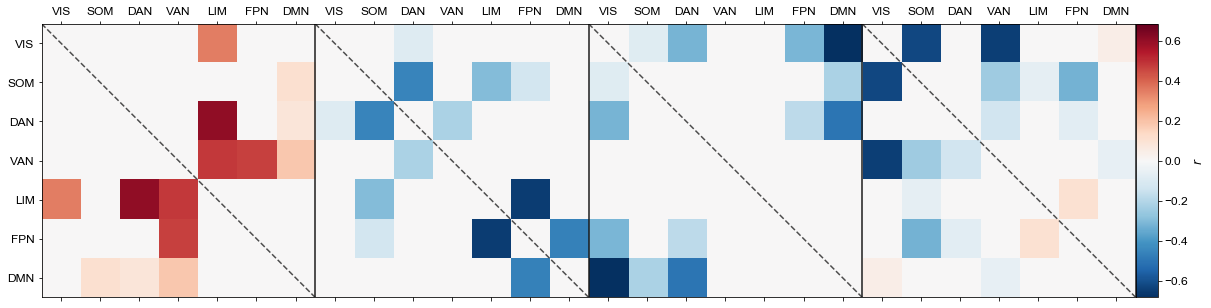

In [56]:
set_text_size(12)
plt.close('all')

mat_plot = np.hstack(u_mat)
cb_max = np.max(np.abs(mat_plot))

fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)
hm = ax.matshow(mat_plot, vmin=-cb_max, vmax=cb_max, cmap=plt.cm.RdBu_r)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0)
cb = fig.colorbar(hm, cax=cax)
cb.set_label(r'$\mathit{r}$')

ax.set_xticks(np.arange(mat_plot.shape[1]))
ax.set_yticks(np.arange(mat_plot.shape[0]))
# ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(dataset['Yeo7_ROIs'] * n)
ax.set_yticklabels(dataset['Yeo7_ROIs'])

for i in range(n):
    ax.plot([ i * 7 + -0.5, i * 7 + len(dataset['Yeo7_ROIs']) - 0.5], [-0.5, len(dataset['Yeo7_ROIs'])-0.5], ls='--', c='.3')
    ax.plot([ i * 7 + 7-0.5, i * 7 + len(dataset['Yeo7_ROIs'])-0.5], [-0.5, len(dataset['Yeo7_ROIs'])-0.5], ls='-', c='.1')
plt.savefig('./reports/Yeo7_variates_FC_H.png', bbox_inches='tight', dpi=300)
plt.show()

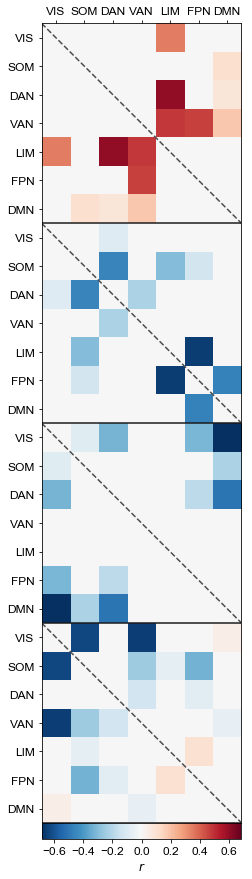

In [57]:
mat_plot = np.vstack(u_mat)
cb_max = np.max(np.abs(mat_plot))

fig = plt.figure(figsize=(6, 15))
ax = fig.add_subplot(111)
hm = ax.matshow(mat_plot, vmin=-cb_max, vmax=cb_max, cmap=plt.cm.RdBu_r)

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="2%", pad=0)
cb = fig.colorbar(hm, cax=cax, orientation='horizontal')
cb.set_label(r'$\mathit{r}$')

ax.set_xticks(np.arange(mat_plot.shape[1]))
ax.set_yticks(np.arange(mat_plot.shape[0]))
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(dataset['Yeo7_ROIs'])
ax.set_yticklabels(dataset['Yeo7_ROIs'] * n)

for i in range(n):
    ax.plot([-0.5, len(dataset['Yeo7_ROIs'])-0.5], [ i * 7 + -0.5, i * 7 + len(dataset['Yeo7_ROIs']) - 0.5], ls='--', c='.3')
    ax.plot([-0.5, len(dataset['Yeo7_ROIs'])-0.5], [ i * 7 + 7-0.5, i * 7 + len(dataset['Yeo7_ROIs'])-0.5], ls='-', c='.1')
plt.savefig('./reports/Yeo7_variates_FC_V.png', bbox_inches='tight', dpi=300)
plt.show()

## Calculating the number of variable occurence among the latent components

In [58]:
n_feature = np.sum(u != 0, axis=1)
idx = np.triu_indices(7, 1)

edges = []
N1 = []
N2 = []
for i, j in zip(idx[0], idx[1]):
    edg = '{}-{}'.format(dataset['Yeo7_ROIs'][i], dataset['Yeo7_ROIs'][j])
    edges.append(edg)
    N1.append(dataset['Yeo7_ROIs'][i])
    N2.append(dataset['Yeo7_ROIs'][j])
    
n_feature_mat = np.zeros((7, 7))
n_feature_mat[idx] = n_feature
n_feature_mat = n_feature_mat.T


n_questions = np.sum(v != 0, axis=1).reshape((31, 1))
df_v = map_labels(n_questions, dataset['MRIQ_labels'])
n_questions, v_labels = rank_labels(df_v.iloc[:, 0])
df_v_count = pd.DataFrame(n_questions, index=v_labels, columns=['count'])
idx = np.isnan(n_questions).reshape((n_questions.shape[0]))
n_questions = n_questions[~idx]
n_questions = n_questions.reshape((n_questions.shape[0], 1))
v_labels = np.array(v_labels)[~idx]

In [59]:
n_feature = n_feature.reshape((21,1))
FC_nfeat = np.concatenate((n_feature, np.array(u != 0, dtype=int)),axis=1)

In [60]:
df_u_count = pd.DataFrame(FC_nfeat, index=[edges, N1, N2], columns=['count', 'comp1', 'comp2', 'comp3', 'comp4'])
df_v_count = pd.DataFrame(n_questions, index=v_labels, columns=['count'])
df_u_count.to_csv('./reports/Yeo7_FC_n_feature.csv')
df_v_count.to_csv('./reports/Yeo7_MRIQ_n_feature.csv')

Plot

In [81]:
for i in range(5):
    print mpl.colors.rgb2hex(colours[i])

#800026
#e31a1c
#fd8e3c
#fed977
#ffffcc


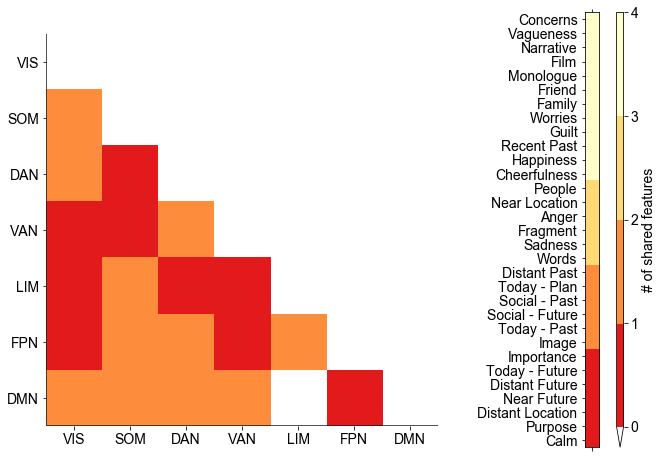

In [82]:
set_text_size(14)
plt.close('all')

colours = mpl.cm.YlOrRd_r(np.linspace(0, 1, n + 1))

cmap = mpl.colors.ListedColormap(['w'] + list(colours)[1:])
cmap.set_over('0')

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
hm = ax.matshow(n_feature_mat, vmin=0, vmax=n, cmap=cmap)
ax.set_xticks(np.arange(n_feature_mat.shape[1]))
ax.set_yticks(np.arange(n_feature_mat.shape[0]))
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(dataset['Yeo7_ROIs'])
ax.set_yticklabels(dataset['Yeo7_ROIs'])
ax.plot([-0.5, -0.5], [-0.5, 6.5], ls='-', c='.1')
ax.plot([-0.5, 6.5], [6.5, 6.5], ls='-', c='.1')

divider = make_axes_locatable(ax)
ax2 = divider.append_axes("right", size="1%", pad=10)
ax2.matshow(n_questions, vmin=0, vmax=n, cmap=cmap)
ax2.set_xticks(np.arange(n_questions.shape[1]))
ax2.set_yticks(np.arange(n_questions.shape[0]))
ax2.set_xticklabels(' ')
ax2.set_yticklabels(v_labels)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="50%", pad=0.25)
bounds = range(0, n + 2)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                # to use 'extend', you must
                                # specify two extra boundaries:
                                boundaries=bounds,
                                extend='min',
                                ticks=bounds,  # optional
                                spacing='proportional',
                                orientation='vertical')
cb.set_ticklabels(range(0, n + 2))
cb.set_label('# of shared features')
plt.savefig('./reports/Yeo7_shared_features.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

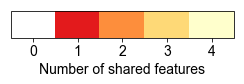

In [98]:
fig = plt.figure(figsize=(4, 0.5))
ax = fig.add_subplot(111)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                # to use 'extend', you must
                                # specify two extra boundaries:
                                boundaries=None,
                                extend='neither',
                                ticks=bounds,  # optional
                                spacing='uniform',
                                orientation='horizontal')
cb.set_ticks(np.array(range(5)) + 0.5)
cb.set_ticklabels(range(5))
cb.set_label('Number of shared features')
plt.savefig('./reports/n_feature_colorbar.png', bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [19]:
print('participant number: ', df.shape[0])
print('participant age: ', np.min(dataset['Age']), np.max(dataset['Age']))
print('participant age mean: ', np.mean(dataset['Age']), np.std(dataset['Age']))
print('participant female: ', np.sum(dataset['Gender']==2))

('participant number: ', 258)
('participant age: ', 18.153424659999999, 54.652054790000001)
('participant age mean: ', 34.971636402286826, 12.244101609924671)
('participant female: ', 162)


In [20]:
np.corrcoef((df.CC_01, df.CC_02, df.CC_03, df.CC_04))

array([[ 1.        , -0.87837492,  0.89086677, -0.76189637],
       [-0.87837492,  1.        , -0.8761642 ,  0.83534886],
       [ 0.89086677, -0.8761642 ,  1.        , -0.82332213],
       [-0.76189637,  0.83534886, -0.82332213,  1.        ]])

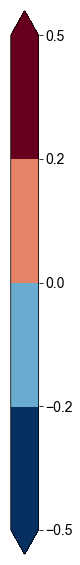

In [102]:
cmap = mpl.colors.ListedColormap(['#053061', '#6aacd0', '#e58368', '#67001f'])
bounds = [-0.5, -0.2, 0., .2, 0.5]

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig = plt.figure(figsize=(0.5, 10))
ax = fig.add_subplot(111)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                # to use 'extend', you must
                                # specify two extra boundaries:
                                boundaries=[-3] + bounds + [3],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform',
                                orientation='vertical')
plt.savefig('./reports/colorbar.png', bbox_inches='tight', dpi=300)
plt.show()

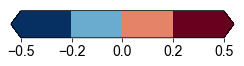

In [103]:
fig = plt.figure(figsize=(4, 0.5))
ax = fig.add_subplot(111)
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                # to use 'extend', you must
                                # specify two extra boundaries:
                                boundaries=[-3] + bounds + [3],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform',
                                orientation='horizontal')
plt.savefig('./reports/colorbar_H.png', bbox_inches='tight', dpi=300)
plt.show()

In [104]:
beta_val = pd.read_table('./reports/rev_paraest.txt', header=None).T
p_val = pd.read_table('./reports/rev_paraest_p.txt', header=None).T

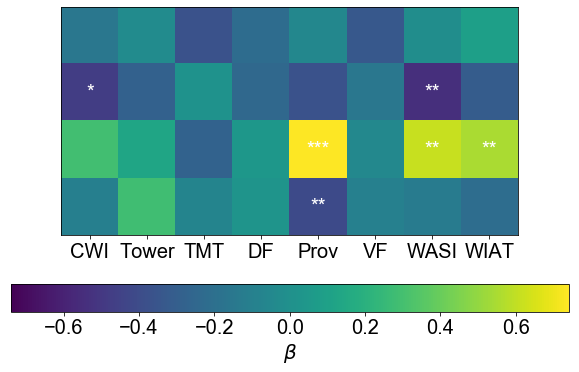

In [31]:
# plot univariate results
set_text_size(20)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

beta = ax.matshow(beta_val.values[1:, :], vmax=np.max(np.abs(beta_val.values)), vmin=-np.max(np.abs(beta_val.values)))
# ax.set_title('Parameter estimation', )
cb = plt.colorbar(beta, orientation='horizontal')
cb.set_label(r'$\beta$')
ax.set_xticks(range(8))
# ax.set_yticks(range(4))
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(['CWI', 'Tower', 'TMT', 'DF', 'Prov', 'VF', 'WASI', 'WIAT'])
ax.set_yticklabels([' ', ' ', ' ', ' '])
ax.tick_params(axis='y', which='both', length=0)
# add significant info
for (j,i),p in np.ndenumerate(p_val.values[1:, :]):
    if p < .001:
        plt.text(i,j,'***',ha='center',va='center', color='white')
    elif p < .01:
        plt.text(i,j,'**',ha='center',va='center', color='white')
    elif p < .05:
        plt.text(i,j,'*',ha='center',va='center', color='white')

plt.savefig('./reports/parameter_estimates_sig_confoundclean.png', bbox_inches='tight', dpi=300)
plt.show()

In [142]:
degen_beta = beta_val.iloc[2:, :].drop([1, 2, 3, 5], 1)
degen_beta.columns = ['CWI', 'Proverb', 'WASI', 'WIAT']

In [262]:
ind = np.arange(3)  # the x locations for the groups
width = 0.1
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
for i in range(4):
    b = ax.bar(ind + width * i, degen_beta.values[:, i], width, label=degen_beta.columns[i])

ax.axhline(0, ls='-', c='black', lw=1)
ax.legend()

ax.plot([0.7, 0.7], [0, 0.05], ls='-', c='black', lw=1)
ax.plot([1.6, 1.6], [0, 0.05], ls='-', c='black', lw=1)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax.set_ylim(-1, 1)
plt.savefig('./reports/degen.png', bbox_inches='tight', dpi=300, transparent=True)

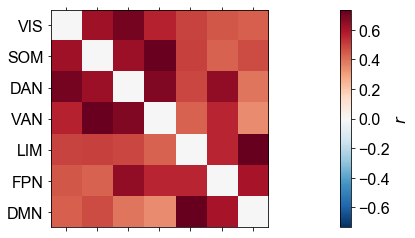

In [15]:
# Calculate the mean
# FC_mean = zscore(np.mean(dataset['FC_Yeo7'], axis=0))
FC_mean = np.mean(dataset['FC_Yeo7'], axis=0)
FC_mat = unflatten(FC_mean)

#Plot
set_text_size(16)
fig = single_heatmap(FC_mat, [' ', ' ', ' ', ' ', ' ', ' ', ' '], 
                     dataset['Yeo7_ROIs'], r'$\mathit{r}$')
plt.savefig('./reports/meanFC_raw.png', bbox_inches='tight', dpi=300)
plt.show()

# Histogram of task data

In [36]:
data = dataset['CognitiveMeasures']
print dataset['CognitiveMeasures_labels']

['DKEFSCWI_40', 'DF_29', 'PROV_16', 'TOWER_57', 'DKEFSTMT_48', 'VF_37', 'INT_17', 'WIAT_08', 'DBDI_22', 'DSEQ_47', 'DSEQ_48', 'UPPS_60', 'UPPS_61', 'UPPS_62', 'UPPS_63', 'UPPS_64']


In [13]:
df_cog = df[['DKEFSCWI_40', 'TOWER_57', 'DKEFSTMT_48', 'DF_29', 'PROV_16', 'VF_37', 'INT_17', 'WIAT_08']]

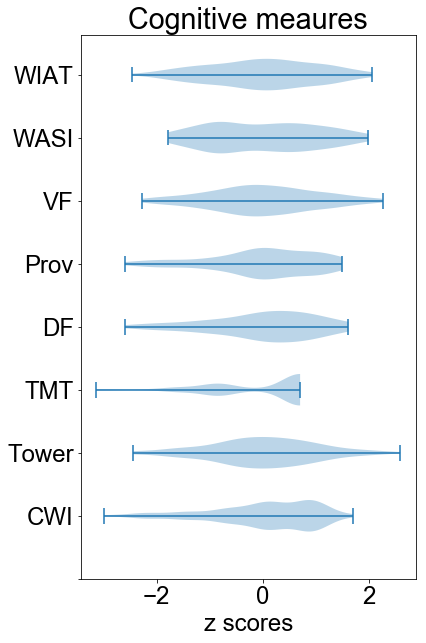

In [14]:
set_text_size(24)
plt.figure(figsize=(6, 10))
plt.violinplot(df_cog.values, vert=False, )
plt.yticks(range(9), ['', 'CWI', 'Tower', 'TMT', 'DF', 'Prov', 'VF', 'WASI', 'WIAT'])
plt.xlabel('z scores')
plt.title('Cognitive meaures')
plt.savefig('./reports/task_dist.png', bbox_inches='tight', dpi=300)
plt.show()

# testing the word cloud package

In [16]:
from wordcloud import WordCloud

In [62]:
dict_v_n = {}
for row in df_v_count.iterrows():
    dict_v_n[row[0]] =  row[1].values[0]

In [70]:
wc = WordCloud(background_color="black", font_step=5, max_font_size=40, 
               height=600, width=600, prefer_horizontal=1,
               font_path='C://Windows//Fonts//arial.ttf')
wc.generate_from_frequencies(dict_v_n)
wc.min_font_size = 14
wc.recolor(colormap='YlOrRd_r')
wc.to_file('test.png')